In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to generate a sample path from Wn

def gen_traj_particle(gen_peds, accels, n, D = 0):
    traj = np.zeros(n+1)
    t = np.zeros(n+1)
    
    gen_peds_chosen = np.random.choice(gen_peds, size=n+1) # regeneration periods
    rho = np.cumsum(gen_peds_chosen) # regeneration points
    a_chosen = np.random.choice(accels, size=n+1) # accelerations
    s = D

    traj[0] = s
    t[0] = 0
    
    # Generate the trajectory
    for k in range(n): # 0 to n-1
        s = D
        for j in range(k+1): # 0 to k (0 to n)
            if j+1 < k+1:
                s = s + a_chosen[j] * (rho[j+1] - rho[j]) * (rho[k] - rho[j+1])
            s = s + 0.5 * a_chosen[j] * (rho[j+1] - rho[j])**2
        traj[k+1] = s
        t[k+1] = rho[k+1]
        
    s = s + 0.5 * a_chosen[n-1] * (rho[n] - rho[n-1])**2
    traj[n] = s
    t[n] = rho[n]
    
    return traj, t

In [3]:
def get_hitting_time(traj, thres=0.5):
    return np.argmax(np.abs(traj) > thres, axis=0)

# One-sided Distribution of Acceleration

Text(0, 0.5, 'Probability density')

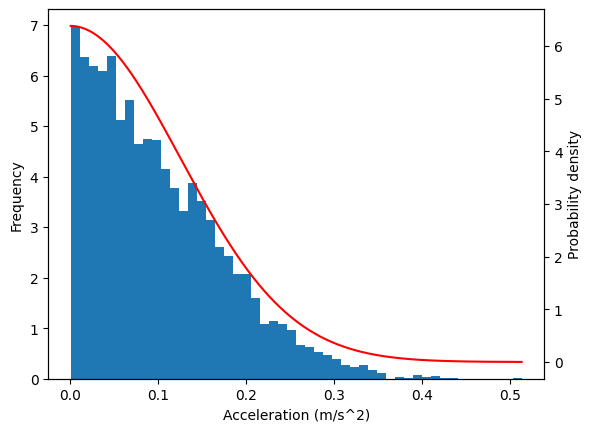

In [4]:
# Generate the acceleration impulses by sampling from a half-normal distribution

from scipy.stats import halfnorm

# Generate the impulses
accel_mean = 0
accel_std = 0.125

accels = halfnorm.rvs(scale=accel_std, size=5000)

# Plot the impulses
fig, ax = plt.subplots()
ax.hist(accels, bins=50, density=True)
plt.xlabel('Acceleration (m/s^2)')
plt.ylabel('Frequency')

# Plot the PDF of the half-normal 
x = np.linspace(np.min(accels), np.max(accels), 1000)
ax2 = ax.twinx()
plt.plot(x, halfnorm.pdf(x, scale=accel_std), color='red')
plt.xlabel('Acceleration (m/s^2)')
plt.ylabel('Probability density')

In [5]:
from scipy.stats import norm

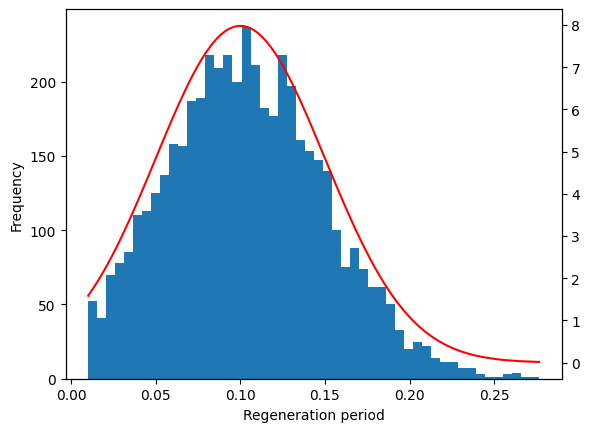

In [6]:
# Generate the regeneration periods (repes) by sampling from a Gaussian distribution with mean 1 and standard deviation 0.1
repes_mean = 0.1
repes_std = 0.05

repes = norm.rvs(loc = repes_mean, scale = repes_std, size = 5000)

# remove all regeneration periods that are smaller than 0
repes = repes[repes > 0.01]

# Check if there is a value of repes that is smaller than 0
assert np.sum(repes < 0) == 0, 'There are {} regeneration periods smaller than zero'.format(np.sum(repes < 0))

# Plot the histogram of the regeneration periods
fig, ax = plt.subplots()
plt.hist(repes, bins = 50)
plt.xlabel('Regeneration period')
plt.ylabel('Frequency')

# Switch to different axis
ax2 = ax.twinx()

# Plot the PDF of the Gaussian distribution
x = np.linspace(np.min(repes), np.max(repes), 100)
plt.plot(x, norm.pdf(x, loc = repes_mean, scale = repes_std), 'r')

In [7]:
trajs = []
ts = []
for i in range(1000):
    traj, t = gen_traj_particle(repes, accels, 300)
    trajs.append(traj)
    ts.append(t)

print('{} trajectories were generated'.format(len(trajs)))

1000 trajectories were generated


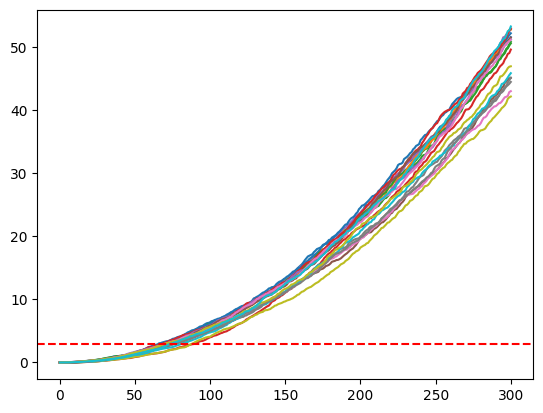

In [10]:
# Plot some trajectory paths 

for i in range(20):
    plt.plot(np.arange(len(trajs[i])), trajs[i], label=f"Trajectory {i}")
    
# draw a horizontal line at y=3
plt.axhline(y=3, color='r', linestyle='--')


In [11]:
hits = []
hitting_indices = []

for i in range(len(trajs)):
    ht = get_hitting_time(trajs[i], thres=3.0) # index of the hitting time / first passage time
    t_ht = ts[i][ht] # the hitting time
    if ht > 0:
        hits.append(t_ht)
        hitting_indices.append(ht)
    
hits = np.array(hits)

Expected number of hits: 8.005579643342292
Never hit: 0  per  1000


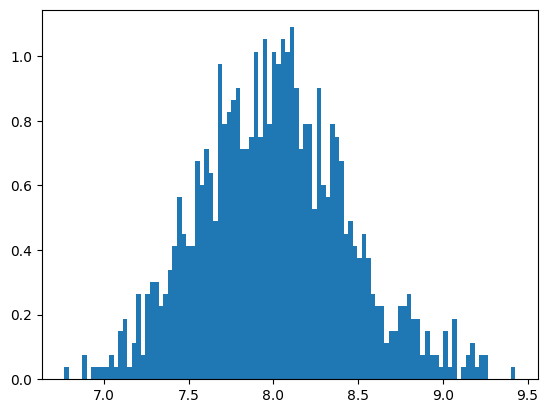

In [12]:
plt.hist(hits, bins=100, density=True, label='hits')
print('Expected number of hits:', np.mean(hits))
print('Never hit:', len(trajs) - len(hits), ' per ', len(trajs))

In [13]:
# Statistical properties for analytical estimation of the stopping time

accel_half_mean = np.mean(accels)
print('Empirical E[Ak] =', accel_half_mean)
print('Theoretical E[Ak] =', halfnorm.mean(scale=accel_half_mean))

repes_mean = np.mean(repes)
repes_var = np.var(repes) + repes_mean**2
print('Empirical REPES mean =', repes_mean)
print('Empirical REPES second moment =', repes_var)

Empirical E[Ak] = 0.10074942089604647
Theoretical E[Ak] = 0.08038640744278507
Empirical REPES mean = 0.10428583660920163
Empirical REPES second moment = 0.012979026210342047


In [16]:
expected_tau = np.sqrt(2 * 3.0 / (accel_half_mean * (repes_mean**2)))
print('Expected stopping time: ', expected_tau * repes_mean)

Expected stopping time:  7.717103872981626


This result seems to be correct!